# Lab-02: Compare LLMs using Ragas Evaluations

### Context

The LLM used in the Retrieval Augmented Generation (RAG) system has a major impact in the quality of the generated output. Evaluating the results generated by different LLMs can give an idea about the right llm to use for a particular use case.
In this notebook, we will dive deep into building Q&A applications using the Retrieve API provide by Knowledge Bases for Amazon Bedrock, along with LangChain and Ragas for evaluating the responses. Here, we will query the knowledge base to get the desired number of document chunks based on similarity search, prompt the query using Anthropic Claude models and Meta Llama models, and then evaluate the responses effectively using evaluation metrics, such as faithfulness, answer_relevancy, context_recall, context_precision, context_entity_recall, answer_similarity, answer_correctness, harmfulness, maliciousness, coherence, correctness and conciseness.

#### Notebook Walkthrough

For our notebook we will use the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into
embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom
workﬂows on top of the semantic search results. The output of the `Retrieve API` includes the the `retrieved text chunks`, the `location type` and `URI` of the source data, as well as the relevance `scores` of the retrievals. 


We will then use the text chunks being generated and augment it with the original prompt and pass it through the `anthropic.claude-3-sonnet-20240229-v1:0` model, the `anthropic.claude-3-haiku-20240307-v1:0` model, and the `amazon.titan-text-express-v1` model.

Finally we will evaluate the generated responses using RAGAS on using metrics such as faithfulness, answer relevancy, and context precision. For evaluation, we will use `anthropic.claude-3-haiku-20240307-v1:0`.

#### Dataset

In this example, you will use Octank's financial 10k reports (sythetically generated dataset) as a text corpus to perform Q&A on. This data will be ingested into the knowledge base.

### Python 3.10

⚠  For this lab we need to run the notebook based on a Python 3.10 runtime. ⚠


## Configuration leveraging knowledge base created from LAB01
We'll use the following data:

* example financial statement documents of fake company "Octank"


In [1]:
import logging
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)
import sagemaker
import boto3
import pprint
from botocore.client import Config

pp = pprint.PrettyPrinter(indent=2)
# Specify your bucket to be the default sagemaker bucket
sess = sagemaker.Session()
bucket = sess.default_bucket() #sagemaker-abcdef
filename = 'octank_financial_10K.pdf'

# Create an S3 client
s3 = boto3.client('s3')

# Upload the file
s3.upload_file(filename, bucket, filename)
print("Upload Successful!!\n")
print(f"{filename} was successfully uploaded to {bucket}/{filename}")

Upload Successful!!

octank_financial_10K.pdf was successfully uploaded to sagemaker-us-east-1-058264176820/octank_financial_10K.pdf


### Initialize Knowledge Base from Previous Lab

In [2]:
from utility import interactive_sleep, create_knowledge_base, create_ds
from langchain_aws import BedrockEmbeddings

boto3_session = boto3.session.Session()
region_name = boto3_session.region_name
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 10})
bedrock_runtime_client = boto3.client('bedrock-runtime', config=bedrock_config)


cohere_embed_knowledge_base = create_knowledge_base(
    index_name="cohere-embed-english-v3", 
    collection_name="cohere-embed-english-v3",
    knowledge_base_name="cohere-embed-english-v3",
    vector_store_name="cohere-embed-english-v3",
    access_policy_name="cohere-embed-access-policy",
    embedding_model_arn=f"arn:aws:bedrock:{region_name}::foundation-model/cohere.embed-english-v3"
    )

bedrock_embeddings = BedrockEmbeddings(model_id="cohere.embed-english-v3",client=bedrock_runtime_client)
print(f"Cohere Embed Knowledge Base Id: {cohere_embed_knowledge_base['knowledgeBaseId']}")

bedrock kb execution role arn:aws:iam::058264176820:role/amazon-sagemaker-base-executionrole
Cohere Embed Knowledge Base Id: O079GGLKHW


### Follow the steps below to set up necessary packages

1. Import the necessary libraries for creating `bedrock-runtime` for invoking foundation models and `bedrock-agent-runtime` client for using Retrieve API provided by Knowledge Bases for Amazon Bedrock. 
2. Import Langchain for: 
   1. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0`, `anthropic.claude-3-sonnet-20240229-v1:0`, and `amazon.titan-text-express-v1` as our large language models to perform query completions using the RAG pattern. 
   2. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0` as our large language model to perform RAG assessment. 
3. Create a `AmazonKnowledgeBasesRetriever` object from LangChain which will call the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom workﬂows on top of the semantic search results.

In [3]:
from langchain.llms.bedrock import Bedrock
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever
from langchain.chains import RetrievalQA
from langchain_aws import ChatBedrock
import pandas as pd


kwargs = {
    "temperature": 0
}

llm_for_text_generation_haiku = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client, model_kwargs=kwargs)

llm_for_text_generation_sonnet = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0", client=bedrock_runtime_client, model_kwargs=kwargs)

llm_for_text_generation_amazon_titan = ChatBedrock(model_id="amazon.titan-text-express-v1", client=bedrock_runtime_client, model_kwargs=kwargs)

llm_for_evaluation = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client, model_kwargs=kwargs)

llms = [llm_for_text_generation_haiku, llm_for_text_generation_sonnet,llm_for_text_generation_amazon_titan]
print ("List of LLMs to be evaluated with Ragas")
for llm in llms:
    print (llm.model_id)

# Create retriever with the knowledge base ID
retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=cohere_embed_knowledge_base["knowledgeBaseId"],
        retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 5}},
        # endpoint_url=endpoint_url,
        # region_name="us-east-1",
        # credentials_profile_name="<profile_name>",
)
print("Retriever created!!")

List of LLMs to be evaluated with Ragas
anthropic.claude-3-haiku-20240307-v1:0
anthropic.claude-3-sonnet-20240229-v1:0
amazon.titan-text-express-v1
Retriever created!!


## Preparing the Evaluation Data

As RAGAS aims to be a reference-free evaluation framework, the required preparations of the evaluation dataset are minimal. You will need to prepare `question` and `ground_truths` pairs from which you can prepare the remaining information through inference as shown below. If you are not interested in the `context_recall` metric, you don’t need to provide the `ground_truths` information. In this case, all you need to prepare are the `questions`.

In [4]:
from datasets import Dataset
from concurrent.futures import ThreadPoolExecutor

questions = [
    "What was the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021?",
    "In which year did Octank Financial have the highest net cash used in investing activities, and what was the primary reason for this?",
    "What was the primary source of cash inflows from financing activities for Octank Financial in 2021?"
]

prefix = "Keep your answers under 2000 characters in length. Only use information you are sure about from the knowledge base. "
questions = [prefix + question for question in questions]

ground_truth = [
    "The increase in net cash provided by operating activities was primarily due to an increase in net income and favorable changes in operating assets and liabilities.",
    "Octank Financial had the highest net cash used in investing activities in 2021, at $360 million, compared to $290 million in 2020 and $240 million in 2019. The primary reason for this was an increase in purchases of property, plant, and equipment and marketable securities.",
    "The primary source of cash inflows from financing activities for Octank Financial in 2021 was an increase in proceeds from the issuance of common stock and long-term debt."
]

def execute_rag(llm):
    answers = []
    contexts = []
    kb_id = retriever.knowledge_base_id
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm, retriever=retriever, return_source_documents=True
    )
    print(f"Answering questions for llm: {llm.model_id}...")
    for query in questions:
        response = qa_chain.invoke(query)
        answers.append(response["result"])
        contexts.append([docs.page_content for docs in response["source_documents"]])
    # To dict
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truth
    }
    return llm.model_id, data

datasets = {}
for llm in llms:
    model_id, data = execute_rag(llm)
    datasets[model_id] = Dataset.from_dict(data)

print("Questions answered and datasets created!!")

Answering questions for llm: anthropic.claude-3-haiku-20240307-v1:0...
Answering questions for llm: anthropic.claude-3-sonnet-20240229-v1:0...
Answering questions for llm: amazon.titan-text-express-v1...
Questions answered and datasets created!!


## Evaluating the RAG application with different LLMs
First, import all the metrics you want to use from `ragas.metrics`. Then, you can use the `evaluate()` function and simply pass in the relevant metrics and the prepared dataset.

In [5]:
#LLM Model RAGAS comparisson

from ragas import evaluate, RunConfig
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_similarity,
    answer_correctness
)

#specify the metrics here
metrics = [
        faithfulness,
        answer_relevancy,
        answer_similarity,
        answer_correctness
    ]

def evaluate_llm(llm, embeddings, datasets, llm_for_evaluation):
    llm_model_id = llm.model_id
    result = evaluate(
        dataset=datasets[llm_model_id],
        metrics=metrics,
        llm=llm_for_evaluation,
        embeddings=embeddings,
        run_config=RunConfig(max_workers=2)
    )
    return llm_model_id, result.to_pandas()

dfs = {}
for i, llm in enumerate(llms):
    model_id, df = evaluate_llm(llm, bedrock_embeddings, datasets, llm_for_evaluation)
    dfs[model_id] = df

print("Ragas evaluation complete!!")
# disregard any "failed to parse output" errors. Those originate from the Ragas library

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Ragas evaluation complete!!


### RAGAS METRICS AND RESULTS ANALYSIS


Just like in any machine learning system, the performance of individual components within the LLM and RAG pipeline has a significant impact on the overall experience. Ragas offers metrics tailored for evaluating each component of your RAG pipeline in isolation


<!-- ![data_ingestion.png](./images/data_ingestion.png) -->
<img src="./assets/RAGASMETRICS_v2.png" width=50% height=20% />
<img src="./assets/RAGASFLOW_v2.png" width=50% height=20% />

Below we will plot the results:

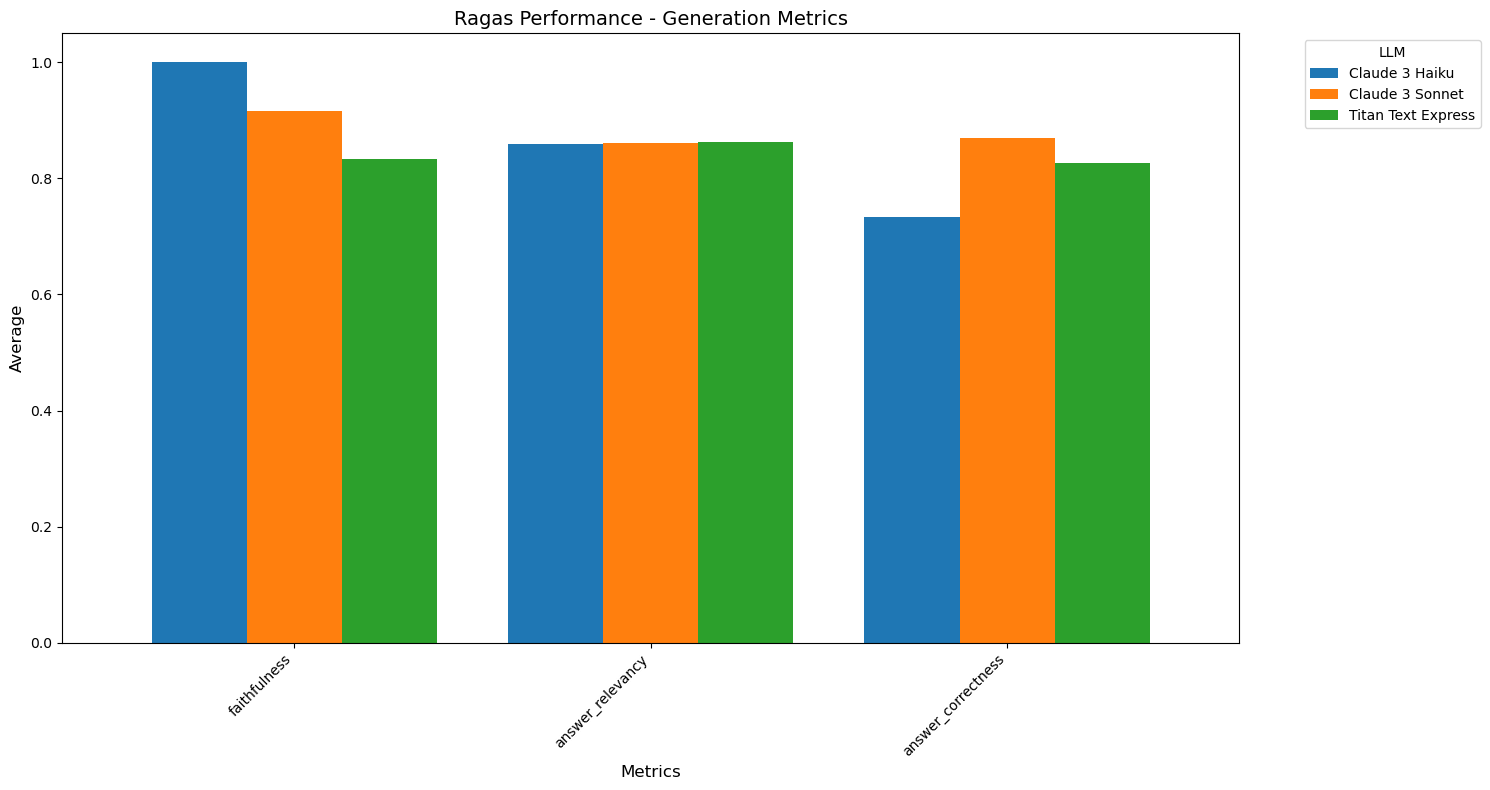

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a mapping for shorter names
name_mapping = {
    'anthropic.claude-3-haiku-20240307-v1:0': 'Claude 3 Haiku',
    'anthropic.claude-3-sonnet-20240229-v1:0': 'Claude 3 Sonnet',
    'amazon.titan-text-express-v1': 'Titan Text Express'
}

numeric_cols = ['faithfulness', 'answer_relevancy',  'answer_correctness']

means = []
llm_names = []
for key, df in dfs.items():
    mean_values = df[numeric_cols].mean()
    means.append(mean_values)
    llm_names.append(key)
    
means_df = pd.DataFrame(means, columns=numeric_cols, index=llm_names)
# Apply the mapping to the index
means_df.index = means_df.index.map(name_mapping)

subset1 = means_df.iloc[:, :4]
plot_df1 = subset1.T

fig1, ax1 = plt.subplots(figsize=(15, 8))
plot_df1.plot(kind='bar', ax=ax1, width=0.8)

ax1.set_title('Ragas Performance - Generation Metrics', fontsize=14)
ax1.set_xlabel('Metrics', fontsize=12)
ax1.set_ylabel('Average', fontsize=12)
plt.xticks(rotation=45, ha='right')
ax1.legend(title='LLM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()